# PBLH Monte Carlo Uncertainty in Geostatistical Framework

## 0. Abstract (very short)

The aim of this notebook is to motivate, explore, and demonstrate the application of a geostatistical framework and Gaussian processes, specifically through the use of the Monte Carlo method, to quantify the uncertainty of planetary boundary layer height (PBLH) in vertical atmospheric profiles derived from radiosonde data.

Disclaimer: work in progress..

## 1. Imports

In [39]:
# lots of them
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from matplotlib.patches import Ellipse
import gstools as gs
from gstools.random import MasterRNG

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from gruanpy import gruanpy as gp
from code_examples.visual_config.color_map import map_labels_to_colors

## 2. Radiosonde Data

In [40]:
# build a list of GDP objects and take one as example
gdps=[]
folder = r'C:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\gdp\icm16' # open folder with chosen GDP files
file_paths = [
    os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.nc')
]
for file_path in tqdm(file_paths[:2]):
    gdp = gp.read(file_path) # read GDP file
    upper_bound=gp._find_upper_bound(gdp.data[['alt']], upper_bound=3500, return_value=True) # find the PBLH upper bound for profile
    gdp.data = gdp.data[gdp.data['alt'] <= upper_bound]  # Limit to first 3.5 km
    gdps.append(gdp) # store GDP object in list
gdp = gdps[0] # select one GDP object for testing
where = gdp.global_attrs[gdp.global_attrs['Attribute'] == 'g.Site.Name']['Value'].values[0]
when = gdp.global_attrs[gdp.global_attrs['Attribute'] == 'g.Measurement.StartTime']['Value'].values[0]
when=when[:10]+' '+when[11:19]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


In [41]:
# main input quantities and their uncertainties
INPUT_QUANT = ['time', 'alt', 'temp', 'rh', 'press', 'wspeed', 'wdir']
INPUT_UNC = [var + '_uc' for var in INPUT_QUANT if var != 'time']
VARIABLES = INPUT_QUANT + INPUT_UNC
print(gdp.data[VARIABLES].head())

                     time         alt        temp         rh       press  \
0 2017-03-03 10:58:21.278  110.165466  283.187256  47.497250  999.941956   
1 2017-03-03 10:58:22.278  114.367882  282.718170  48.346027  999.432922   
2 2017-03-03 10:58:23.278  118.070015  282.335724  49.299541  998.982605   
3 2017-03-03 10:58:24.278  122.772713  282.039246  50.185566  998.409851   
4 2017-03-03 10:58:25.278  126.174660  281.818146  50.901218  998.002258   

     wspeed        wdir     alt_uc   temp_uc     rh_uc  press_uc  wspeed_uc  \
0  5.689131  190.263504  17.097971  0.428046  2.055459  2.962642   4.422800   
1  5.761503  190.114807  17.782423  0.430434  2.069524  2.970972   4.394663   
2  5.907081  189.882599  17.097260  0.443847  2.151899  2.969656   4.320349   
3  6.125365  189.564148  17.096903  0.459696  2.222719  2.967964   4.451875   
4  6.407086  189.211639  17.096542  0.472302  2.274520  2.966758   4.672499   

     wdir_uc  
0  28.717716  
1  28.190800  
2  27.488783  
3  26.33

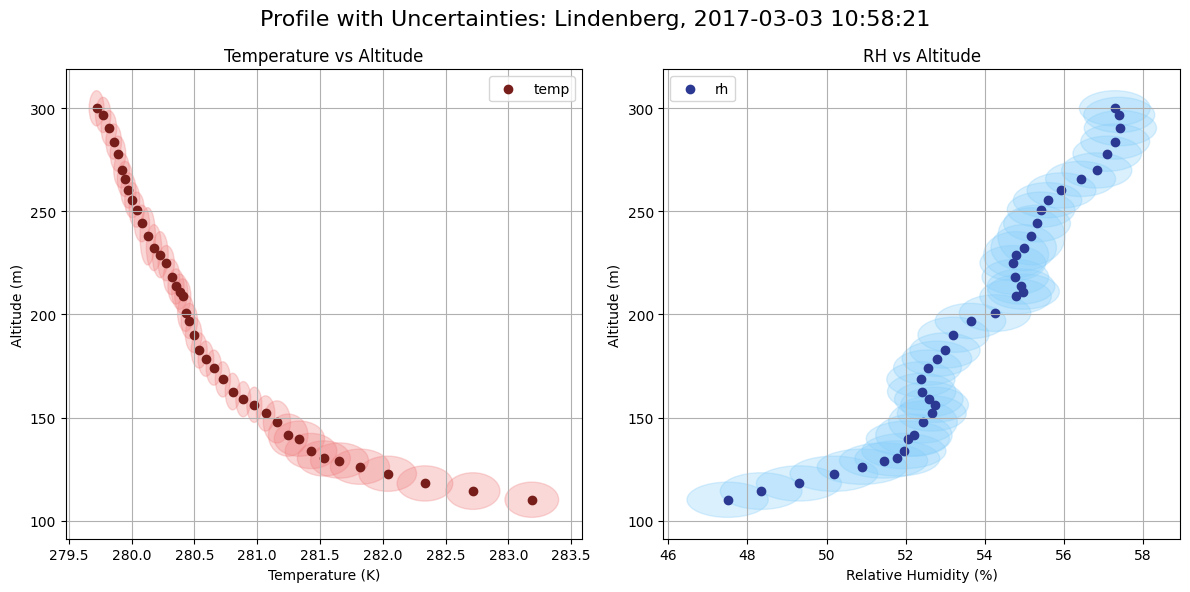

In [42]:
# fancy plot 
plt.figure(figsize=(12, 6))
plt.suptitle(f'Profile with Uncertainties: {where}, {when}', fontsize=16)
mask = gdp.data['alt'] <= 300

# Plot temperature vs altitude with uncertainty ellipses
plt.subplot(1, 2, 1)
for t, a, t_uc, a_uc in zip(gdp.data['temp'][mask], gdp.data['alt'][mask], gdp.data['temp_uc'][mask], gdp.data['alt_uc'][mask]):
    ellip = Ellipse((t, a), t_uc, a_uc, color=map_labels_to_colors['temp_uc'], alpha=0.3)
    plt.gca().add_patch(ellip)
plt.scatter(gdp.data['temp'][mask], gdp.data['alt'][mask],
            color=map_labels_to_colors['temp'], label='temp')
plt.xlabel('Temperature (K)')
plt.ylabel('Altitude (m)')
plt.title('Temperature vs Altitude')
plt.grid(True)
plt.legend()

# Plot RH vs altitude with uncertainty ellipses
plt.subplot(1, 2, 2)
for rh, a, rh_uc, a_uc in zip(gdp.data['rh'][mask], gdp.data['alt'][mask], gdp.data['rh_uc'][mask], gdp.data['alt_uc'][mask]):
    ellip = Ellipse((rh, a), rh_uc, a_uc, color=map_labels_to_colors['rh_uc'], alpha=0.3)
    plt.gca().add_patch(ellip)
plt.scatter(gdp.data['rh'][mask], gdp.data['alt'][mask], color=map_labels_to_colors['rh'], label='rh')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Altitude (m)')
plt.title('RH vs Altitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 3. PBLH Methods on Radiosonde Data

Intermadiate variable:
- saturation vapor pressure, $e_s$, by Tetens equation 
$$e_s=6.1078\,exp\Big(\frac{17.27 (T - 273.16)}{T - 35.86}\Big)$$
- water vapor pressure, $e$, from $RH$
$$e=\frac{RH\,e_s}{100}$$
- virtual temperature, $T_v$
$$T_v=\frac{T}{1-\frac{e}{p}(1-\varepsilon)}$$
- potential temperature, $\theta$, by Poisson's equation
$$\theta= T\Big(\frac{p_0}{p}\Big)^{R_d/c_{pd}}$$
- water vapor saturation mass, $w_s$
$$w_s=\frac{\epsilon\,e_s}{p-e_s}$$
- mixing ration, $w$
$$w=\frac{RH\,w_s}{100}$$
- specific humidity, $q$
$$q=\frac{w}{1+w}$$
- potential temperature gradient, $\Gamma_\theta$, by finite difference ratio
$$\Gamma_\theta=\frac{\Delta \theta}{\Delta z}$$
- RH gradient, $\Gamma_{RH}$, by finite difference ratio
$$\Gamma_{RH}=\frac{\Delta RH}{\Delta z}$$
- specific humidity gradient, $\Gamma_q$, by finite difference ratio
$$\Gamma_q=\frac{\Delta q}{\Delta z}$$
- wind components, $uspeed,\,vspeed$
$$uspeed=wspeed\,\cos(wdir)$$
$$vspeed=wspeed\,\sin(wdir)$$
- bulk richardson number, $Ri_b$
$$Ri_b=\frac{(g/\theta_{v_s})(\theta_v-\theta_{v_s})z}{uspeed^2+vspeed^2}$$

In [46]:
def apply_pblh_methods(data):
    data = gp.parcel_method(data) # calculate PBLH using parcel method
    data = gp.potential_temperature_gradient(data, virtual=True) # calculate potential temperature gradient
    data = gp.RH_gradient(data) # calculate RH gradient
    data = gp.specific_humidity_gradient(data) # calculate specific humidity gradient
    data = gp.bulk_richardson_number_method(data) # calculate gradient Richardson number
    return data

def find_pblh(data):
    pblh_pm = data['alt'][data['pblh_pm'] == 1].iloc[0] if 'pblh_pm' in data and any(data['pblh_pm'] == 1) else None
    pblh_theta = data['alt'][data['pblh_theta'] == 1].iloc[0] if 'pblh_theta' in data and any(data['pblh_theta'] == 1) else None 
    pblh_rh = data['alt'][data['pblh_rh'] == 1].iloc[0] if 'pblh_rh' in data and any(data['pblh_rh'] == 1) else None
    pblh_q = data['alt'][data['pblh_q'] == 1].iloc[0] if 'pblh_q' in data and any(data['pblh_q'] == 1) else None
    pblh_Ri = data['alt'][data['pblh_Ri'] == 1].iloc[0] if 'pblh_Ri' in data and any(data['pblh_Ri'] == 1) else None
    return pblh_pm, pblh_theta, pblh_rh, pblh_q, pblh_Ri

In [47]:
gdp.data = apply_pblh_methods(gdp.data)

In [48]:
# main intermadiate variables
intermediate_variables = ['es', 'e', 'virtual_temp', 'virtual_theta', 'q', 'theta_gradient', 'rh_gradient', 'q_gradient', 'Ri_b']
print(gdp.data[intermediate_variables].head())

          es         e  virtual_temp  virtual_theta         q  theta_gradient  \
0  12.301666  5.842953    283.814148     283.818848  0.003666             NaN   
1  11.920365  5.763023    283.335754     283.381622  0.003617       -0.104041   
2  11.617223  5.727238    282.948914     283.031128  0.003595       -0.094674   
3  11.386910  5.714586    282.650757     282.779175  0.003588       -0.053576   
4  11.217778  5.709986    282.428955     282.590179  0.003586       -0.055555   

   rh_gradient    q_gradient      Ri_b  
0          NaN           NaN  0.000000  
1     0.201974 -1.178055e-05 -0.035616  
2     0.257558 -5.900366e-06 -0.063886  
3     0.188408 -1.419007e-06 -0.083141  
4     0.210366 -5.922149e-07 -0.094450  


PBLH Measurement model:
- Parcel method, $z_{pm}^*=inf\{z:\theta-\theta_s\geq0\}$
- Max. grad. $\theta$, $z_\theta^*=argmax_z(\Gamma_\theta)$
- Min. grad. $RH$, $z_{RH}^*=argmin_z(\Gamma_{RH})$
- Min. grad. $q$, $z_q^*=argmin_z(\Gamma_q)$ (FM: più affine a modelli)
- Richardson number, $z_{Ri}^*=inf\{Ri_b>Ri_c\}$

In [49]:
pblh_pm , pblh_theta , pblh_rh , pblh_q , pblh_Ri  = find_pblh(gdp.data)
print(f'PBLH Estimates (m):\nParcel Method: {pblh_pm}\nTheta Gradient: {pblh_theta}\nRH Gradient: {pblh_rh}\nSpecific Humidity Gradient: {pblh_q}\nBulk Richardson Number: {pblh_Ri}')

PBLH Estimates (m):
Parcel Method: 1282.5267333984375
Theta Gradient: 1333.136962890625
RH Gradient: 893.6213989257812
Specific Humidity Gradient: 879.4166259765625
Bulk Richardson Number: 1293.9290771484375


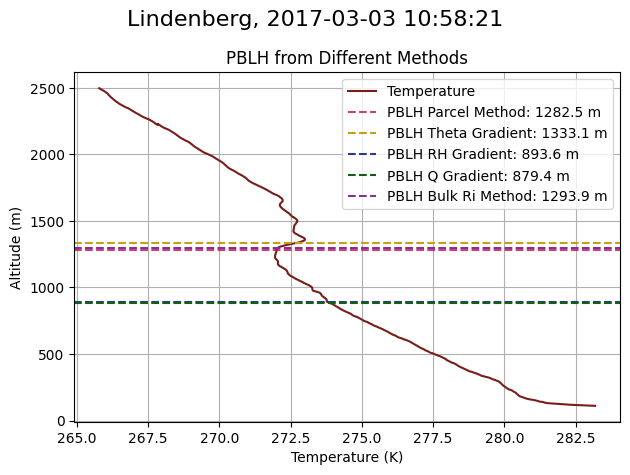

In [50]:
mask = gdp.data['alt'] <= 2500
plt.figure()
plt.suptitle(f'{where}, {when}', fontsize=16)
plt.plot(gdp.data['temp'][mask], gdp.data['alt'][mask], label='Temperature', color=map_labels_to_colors['temp'])
if pblh_pm:
    plt.axhline(pblh_pm, color=map_labels_to_colors['pblh_pm'], linestyle='--', label=f'PBLH Parcel Method: {pblh_pm:.1f} m')
if pblh_theta:
    plt.axhline(pblh_theta, color=map_labels_to_colors['pblh_theta'], linestyle='--', label=f'PBLH Theta Gradient: {pblh_theta:.1f} m')
if pblh_rh:
    plt.axhline(pblh_rh, color=map_labels_to_colors['pblh_rh'], linestyle='--', label=f'PBLH RH Gradient: {pblh_rh:.1f} m')
if pblh_q:
    plt.axhline(pblh_q, color=map_labels_to_colors['pblh_q'], linestyle='--', label=f'PBLH Q Gradient: {pblh_q:.1f} m')
if pblh_Ri:
    plt.axhline(pblh_Ri, color=map_labels_to_colors['pblh_Ri'], linestyle='--', label=f'PBLH Bulk Ri Method: {pblh_Ri:.1f} m')
plt.xlabel('Temperature (K)')
plt.ylabel('Altitude (m)')
plt.title('PBLH from Different Methods')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

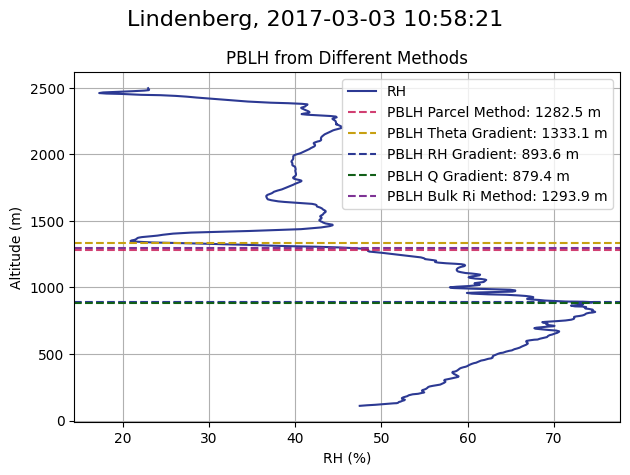

In [51]:
mask = gdp.data['alt'] <= 2500
plt.figure()
plt.suptitle(f'{where}, {when}', fontsize=16)
plt.plot(gdp.data['rh'][mask], gdp.data['alt'][mask], label='RH', color=map_labels_to_colors['rh'])
if pblh_pm:
    plt.axhline(pblh_pm, color=map_labels_to_colors['pblh_pm'], linestyle='--', label=f'PBLH Parcel Method: {pblh_pm:.1f} m')
if pblh_theta:
    plt.axhline(pblh_theta, color=map_labels_to_colors['pblh_theta'], linestyle='--', label=f'PBLH Theta Gradient: {pblh_theta:.1f} m')
if pblh_rh:
    plt.axhline(pblh_rh, color=map_labels_to_colors['pblh_rh'], linestyle='--', label=f'PBLH RH Gradient: {pblh_rh:.1f} m')
if pblh_q:
    plt.axhline(pblh_q, color=map_labels_to_colors['pblh_q'], linestyle='--', label=f'PBLH Q Gradient: {pblh_q:.1f} m')
if pblh_Ri:
    plt.axhline(pblh_Ri, color=map_labels_to_colors['pblh_Ri'], linestyle='--', label=f'PBLH Bulk Ri Method: {pblh_Ri:.1f} m')
plt.xlabel('RH (%)')
plt.ylabel('Altitude (m)')
plt.title('PBLH from Different Methods')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Geostatistical MC Uncertainty

### 4.0 Problem formulation

The follow comes from " Uncertainty of measurement; Supplement 1: Propagation of distributions using a Monte Carlo method" (GUM)

Given a mathematical model of measurement $\boldsymbol{Y}=f(\boldsymbol{X})$ and probability density function (PDF) of each input quantity $X_i$ it si possible to give an estimate of the measurand $\boldsymbol{Y}$ and its measurement uncertainty.

Four different approaches are considered:
- formal definition for PDF of $\boldsymbol{Y}$
- GUM uncertainty framework (First order Taylor series approximation)
- higher order terms Taylor series approximation
- numerical methods, such as Monte Carlo Method (MCM)

Conditions for the applications of the fist 3 approaches are not met in PBLH application. Especially, because of the not differentiability of the measurement model (None of the PBLH method is differentiable). So a numerical approach must be used.

GUM describe the MCM has follow:
1. select a number $M$ of MC trials,
2. generate $M$ vectors of input quantities by sampling from assigned PDFs,
3. compute $M$ model values of $\boldsymbol{Y}$,
4. obtain an estimation for the PDF of $\boldsymbol{Y}$ from $M$ values,
5. use such PDF to express the estimate and the coverage interval/uncertainty of $\boldsymbol{Y}$.

In this application the generare Geostatistic framework is to consider each observed inpunt quantity X s.t.
$$X=S+\epsilon$$
where $S$ is the true value of the atmosphere, and $\epsilon$ is the measurement error.
Different characterization of both those elements brings to different application of the MCM.

### 4.1 Independent Gaussian white noise $\epsilon$

RS41-GDP.1 provide a measurement estimation and the relative expanded uncertainty, with coverage factor $k=2$ for each input quantity.

If each measurement is assumed to respect a Normal distribution and to be independent from other measurement, then each measurement PDF can be characterize just by the measurement estimation  as mean and half the expanded uncertainty as standard deviation.

I am modelling the measurument of a generic input quantities as follow:
$$x=\mu+\epsilon$$
where $\mu$ is the "true value" and $\epsilon$ is the measurement error s.t. $\epsilon\sim N(0,\sigma_x)$, $\sigma_x$ is taken to be equal to the standard uncertainty of a measurement, $\sigma_x=u(x)/k$.


In [64]:
M = 250
noisy_profiles = []
pblh_samples = {'pm': [], 'theta': [], 'rh': [], 'q': [], 'Ri': []}
NOISE_COEF = 0.5 # divide by k=2 to regain the standard combined uncertainty
for _ in tqdm(range(M)):
    data_noisy = gdp.data[VARIABLES].copy(deep=True) # make a copy of the data to add noise to
    if True: # control to add noise to altitude or not
        data_noisy['alt'] = gp.gaussian_noise(data_noisy['alt'], data_noisy['alt_uc']*NOISE_COEF) # add noise to altitude
        data_noisy=data_noisy.sort_values('alt').reset_index(drop=True) # sort by altitude after noise addition
    for var in INPUT_QUANT[2:]:  # skip 'time' and 'alt'
        data_noisy[var] = gp.gaussian_noise(data_noisy[var], data_noisy[var+'_uc']*NOISE_COEF) # add noise to variable
    data_noisy = apply_pblh_methods(data_noisy) # recalculate PBLH estimates on noisy profile
    noisy_profiles.append(data_noisy) # store noisy profile
    # extract PBLH estimates from noisy profile
    pblh_pm, pblh_theta, pblh_rh, pblh_q, pblh_Ri = find_pblh(data_noisy)
    pblh_samples['pm'].append(pblh_pm)
    pblh_samples['theta'].append(pblh_theta)
    pblh_samples['rh'].append(pblh_rh)
    pblh_samples['q'].append(pblh_q)
    pblh_samples['Ri'].append(pblh_Ri)
    # compute mean and stddev of PBLH estimates from Monte Carlo samples
pblh_uncertainty = {
    'pm': (np.nanmean(pblh_samples['pm']), np.nanstd(pblh_samples['pm'], ddof=1)),
    'theta': (np.nanmean(pblh_samples['theta']), np.nanstd(pblh_samples['theta'],ddof=1)),
    'rh': (np.nanmean(pblh_samples['rh']), np.nanstd(pblh_samples['rh'], ddof=1)),
    'q': (np.nanmean(pblh_samples['q']), np.nanstd(pblh_samples['q'], ddof=1)),
    'Ri': (np.nanmean(pblh_samples['Ri']), np.nanstd(pblh_samples['Ri'], ddof=1)),
}

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:07<00:00, 35.34it/s]


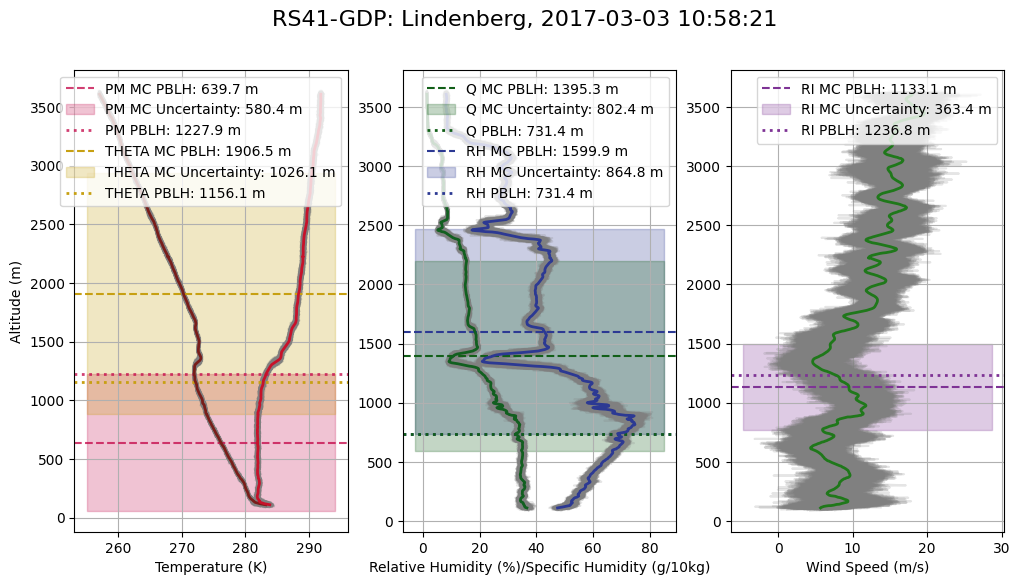

In [65]:
# plot noisy profiles with pblh estimates and uncertainties
plt.figure(figsize=(12, 6))
plt.suptitle(f'RS41-GDP: {where}, {when}'#, {file_index}'
            , fontsize=16)
# Temperature plot
ax1 = plt.subplot(1, 3, 1)
for sample in noisy_profiles: # plot all noisy profiles
    ax1.plot(sample['temp'], sample['alt'], color='gray', alpha=0.2)
    ax1.plot(sample['virtual_theta'], sample['alt'], color='gray', alpha=0.2)
ax1.plot(gdp.data['temp'], gdp.data['alt'], #label='True Temperature',
            color=map_labels_to_colors['temp'], linewidth=2, zorder=5) # plot true temperature
ax1.plot(gdp.data['virtual_theta'], gdp.data['alt'], #label='True Virtual Potential Temperature', 
                    color=map_labels_to_colors['virtual_theta'], linewidth=2, zorder=5) # plot true virtual potential temperature
if pblh_pm is not None: # plot PBLH line
    ax1.axhline(pblh_pm, color=map_labels_to_colors['pblh_pm'], linestyle=':', linewidth=2, label=f'PM PBLH: {pblh_pm:.1f} m')
if pblh_theta is not None: # plot PBLH line
    ax1.axhline(pblh_theta, color=map_labels_to_colors['pblh_theta'], linestyle=':', linewidth=2, label=f'THETA PBLH: {pblh_theta:.1f} m')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (m)')
ax1.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax1.get_xlim()[0],ax1.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    temperature_methods=['pm', 'theta']
    if mean is not None and label in temperature_methods:
        ax1.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax1.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# RH plot
ax2 = plt.subplot(1, 3, 2)
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['rh'], sample['alt'], color='gray', alpha=0.2)
ax2.plot(gdp.data['rh'], gdp.data['alt'], #label='True RH', 
            color=map_labels_to_colors['rh'], linewidth=2, zorder=5) # plot true RH
ax2.plot(gdp.data['q']*10000, gdp.data['alt'], #label='True Specific Humidity', 
                color=map_labels_to_colors['q'], linewidth=2, zorder=5) # plot true specific humidity
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['q']*10000, sample['alt'], color='gray', alpha=0.2)
if pblh_rh is not None: # plot PBLH line
    ax2.axhline(pblh_rh, color=map_labels_to_colors['pblh_rh'], linestyle=':', linewidth=2, label=f'RH PBLH: {pblh_rh:.1f} m')
if pblh_q is not None:
    ax2.axhline(pblh_q, color=map_labels_to_colors['pblh_q'], linestyle=':', linewidth=2, label=f'Q PBLH: {pblh_q:.1f} m')
ax2.set_xlabel('Relative Humidity (%)/Specific Humidity (g/10kg)')
ax2.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax2.get_xlim()[0],ax2.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    humidity_methods=['rh', 'q']
    if mean is not None and label in humidity_methods:
        ax2.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax2.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# wind speed plot
ax3 = plt.subplot(1, 3, 3)
for sample in noisy_profiles: # plot all noisy profiles
    ax3.plot(sample['wspeed'], sample['alt'], color='gray', alpha=0.2)
ax3.plot(gdp.data['wspeed'], gdp.data['alt'], #label='True Wind Speed', 
            color=map_labels_to_colors['wspeed'], linewidth=2, zorder=5) # plot true wind speed
if pblh_Ri is not None: # plot PBLH line
    ax3.axhline(pblh_Ri, color=map_labels_to_colors['pblh_Ri'], linestyle=':', linewidth=2, label=f'RI PBLH: {pblh_Ri:.1f} m')
ax3.set_xlabel('Wind Speed (m/s)')
ax3.grid()
# Add PBLH lines and uncertainty bands
for label, (mean, std) in pblh_uncertainty.items():
    if mean is not None and label in ['Ri']:
        ax3.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax3.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=ax3.get_xlim()[0],
            x2=ax3.get_xlim()[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')


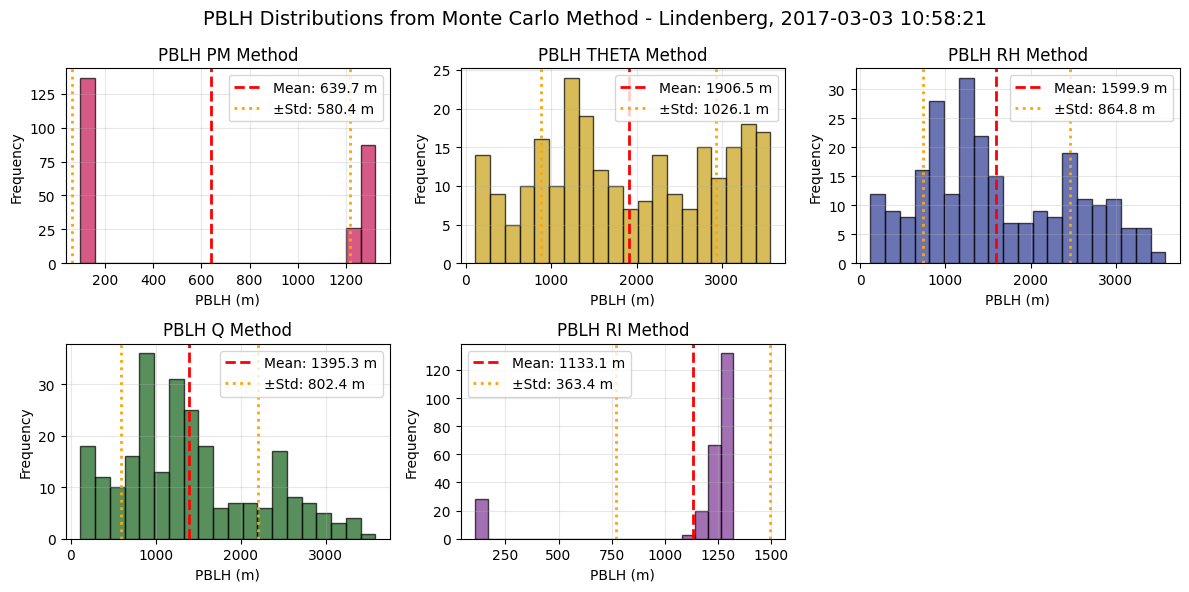

In [66]:
plt.figure(figsize=(12, 6))
methods = ['pm', 'theta', 'rh', 'q', 'Ri']
for idx, method in enumerate(methods, 1):
    plt.subplot(2, 3, idx)
    # Filter out None values
    samples = [s for s in pblh_samples[method] if s is not None]
    plt.hist(samples, bins=20, color=map_labels_to_colors['pblh_'+method], alpha=0.7, edgecolor='black')
    mean = np.nanmean(pblh_samples[method])
    std = np.nanstd(pblh_samples[method], ddof=1)
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f} m')
    plt.axvline(mean - std, color='orange', linestyle=':', linewidth=2, label=f'±Std: {std:.1f} m')
    plt.axvline(mean + std, color='orange', linestyle=':', linewidth=2)
    plt.xlabel('PBLH (m)')
    plt.ylabel('Frequency')
    plt.title(f'PBLH {method.upper()} Method')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle(f'PBLH Distributions from Monte Carlo Method - {where}, {when}', fontsize=14)
plt.tight_layout()
plt.show()

c:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


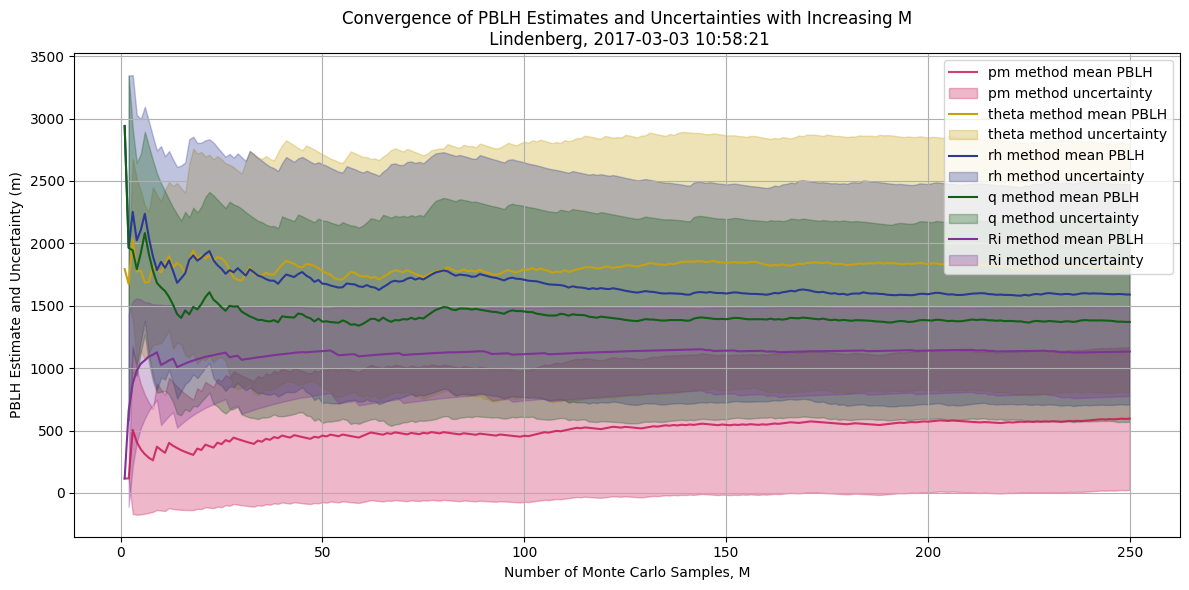

In [18]:
# compute mean and stddev of PBLH estimates with increasing M from Monte Carlo samples
increasing_M_results = []
for M in range(1, M+1):
    pblh_unc = {
        'pm': (np.nanmean(pblh_samples['pm'][:M]), np.nanstd(pblh_samples['pm'][:M], ddof=1)),
        'theta': (np.nanmean(pblh_samples['theta'][:M]), np.nanstd(pblh_samples['theta'][:M],ddof=1)),
        'rh': (np.nanmean(pblh_samples['rh'][:M]), np.nanstd(pblh_samples['rh'][:M], ddof=1)),
        'q': (np.nanmean(pblh_samples['q'][:M]), np.nanstd(pblh_samples['q'][:M], ddof=1)),
        'Ri': (np.nanmean(pblh_samples['Ri'][:M]), np.nanstd(pblh_samples['Ri'][:M], ddof=1)),
    }
    increasing_M_results.append(pblh_unc)
methods = ['pm', 'theta', 'rh', 'q', 'Ri']
plt.figure(figsize=(12, 6))

for method in methods:
    plbhs=[result[method][0] for result in increasing_M_results]
    uncs=[result[method][1] for result in increasing_M_results]
    plt.plot(range(1, M+1), plbhs, label=f'{method} method mean PBLH', color=map_labels_to_colors['pblh_'+method])
    plt.fill_between(range(1, M+1), np.array(plbhs) - np.array(uncs), np.array(plbhs) + np.array(uncs), alpha=0.3, 
                    label=f'{method} method uncertainty', color=map_labels_to_colors['pblh_'+method])

plt.xlabel('Number of Monte Carlo Samples, M')
plt.ylabel('PBLH Estimate and Uncertainty (m)')
plt.title(f'Convergence of PBLH Estimates and Uncertainties with Increasing M\n {where}, {when}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
M = 250
noisy_profiles = []
pblh_samples = {'pm': [], 'theta': [], 'rh': [], 'q': [], 'Ri': []}
NOISE_COEF = 0.5 # divide by k=2 to regain the standard combined uncertainty
for _ in tqdm(range(M)):
    data_noisy = gdp.data[VARIABLES].copy(deep=True) # make a copy of the data to add noise to
    if False: # control to add noise to altitude or not
        data_noisy['alt'] = gp.gaussian_noise(data_noisy['alt'], data_noisy['alt_uc']*NOISE_COEF) # add noise to altitude
        data_noisy=data_noisy.sort_values('alt').reset_index(drop=True) # sort by altitude after noise addition
    for var in INPUT_QUANT[2:]:  # skip 'time' and 'alt'
        data_noisy[var] = gp.gaussian_noise(data_noisy[var], data_noisy[var+'_uc']*NOISE_COEF) # add noise to variable
    data_noisy = apply_pblh_methods(data_noisy) # recalculate PBLH estimates on noisy profile
    noisy_profiles.append(data_noisy) # store noisy profile
    # extract PBLH estimates from noisy profile
    pblh_pm, pblh_theta, pblh_rh, pblh_q, pblh_Ri = find_pblh(data_noisy)
    pblh_samples['pm'].append(pblh_pm)
    pblh_samples['theta'].append(pblh_theta)
    pblh_samples['rh'].append(pblh_rh)
    pblh_samples['q'].append(pblh_q)
    pblh_samples['Ri'].append(pblh_Ri)
    # compute mean and stddev of PBLH estimates from Monte Carlo samples
pblh_uncertainty = {
    'pm': (np.nanmean(pblh_samples['pm']), np.nanstd(pblh_samples['pm'], ddof=1)),
    'theta': (np.nanmean(pblh_samples['theta']), np.nanstd(pblh_samples['theta'],ddof=1)),
    'rh': (np.nanmean(pblh_samples['rh']), np.nanstd(pblh_samples['rh'], ddof=1)),
    'q': (np.nanmean(pblh_samples['q']), np.nanstd(pblh_samples['q'], ddof=1)),
    'Ri': (np.nanmean(pblh_samples['Ri']), np.nanstd(pblh_samples['Ri'], ddof=1)),
}

100%|██████████| 250/250 [00:03<00:00, 67.76it/s]


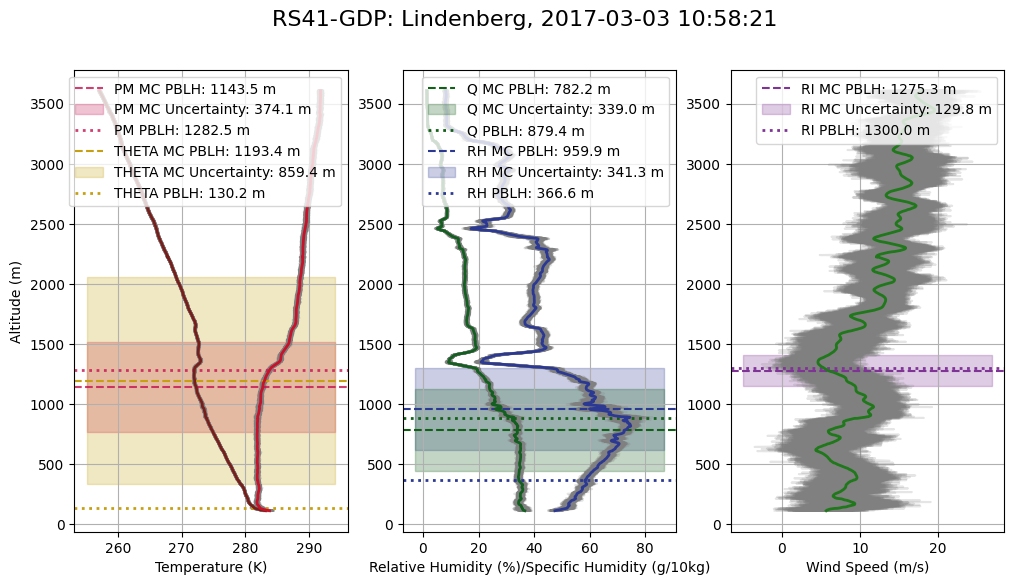

In [20]:
# plot noisy profiles with pblh estimates and uncertainties
plt.figure(figsize=(12, 6))
plt.suptitle(f'RS41-GDP: {where}, {when}'#, {file_index}'
            , fontsize=16)
# Temperature plot
ax1 = plt.subplot(1, 3, 1)
for sample in noisy_profiles: # plot all noisy profiles
    ax1.plot(sample['temp'], sample['alt'], color='gray', alpha=0.2)
    ax1.plot(sample['virtual_theta'], sample['alt'], color='gray', alpha=0.2)
ax1.plot(gdp.data['temp'], gdp.data['alt'], #label='True Temperature',
            color=map_labels_to_colors['temp'], linewidth=2, zorder=5) # plot true temperature
ax1.plot(gdp.data['virtual_theta'], gdp.data['alt'], #label='True Virtual Potential Temperature', 
                    color=map_labels_to_colors['virtual_theta'], linewidth=2, zorder=5) # plot true virtual potential temperature
if pblh_pm is not None: # plot PBLH line
    ax1.axhline(pblh_pm, color=map_labels_to_colors['pblh_pm'], linestyle=':', linewidth=2, label=f'PM PBLH: {pblh_pm:.1f} m')
if pblh_theta is not None: # plot PBLH line
    ax1.axhline(pblh_theta, color=map_labels_to_colors['pblh_theta'], linestyle=':', linewidth=2, label=f'THETA PBLH: {pblh_theta:.1f} m')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (m)')
ax1.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax1.get_xlim()[0],ax1.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    temperature_methods=['pm', 'theta']
    if mean is not None and label in temperature_methods:
        ax1.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax1.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# RH plot
ax2 = plt.subplot(1, 3, 2)
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['rh'], sample['alt'], color='gray', alpha=0.2)
ax2.plot(gdp.data['rh'], gdp.data['alt'], #label='True RH', 
            color=map_labels_to_colors['rh'], linewidth=2, zorder=5) # plot true RH
ax2.plot(gdp.data['q']*10000, gdp.data['alt'], #label='True Specific Humidity', 
                color=map_labels_to_colors['q'], linewidth=2, zorder=5) # plot true specific humidity
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['q']*10000, sample['alt'], color='gray', alpha=0.2)
if pblh_rh is not None: # plot PBLH line
    ax2.axhline(pblh_rh, color=map_labels_to_colors['pblh_rh'], linestyle=':', linewidth=2, label=f'RH PBLH: {pblh_rh:.1f} m')
if pblh_q is not None:
    ax2.axhline(pblh_q, color=map_labels_to_colors['pblh_q'], linestyle=':', linewidth=2, label=f'Q PBLH: {pblh_q:.1f} m')
ax2.set_xlabel('Relative Humidity (%)/Specific Humidity (g/10kg)')
ax2.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax2.get_xlim()[0],ax2.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    humidity_methods=['rh', 'q']
    if mean is not None and label in humidity_methods:
        ax2.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax2.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# wind speed plot
ax3 = plt.subplot(1, 3, 3)
for sample in noisy_profiles: # plot all noisy profiles
    ax3.plot(sample['wspeed'], sample['alt'], color='gray', alpha=0.2)
ax3.plot(gdp.data['wspeed'], gdp.data['alt'], #label='True Wind Speed', 
            color=map_labels_to_colors['wspeed'], linewidth=2, zorder=5) # plot true wind speed
if pblh_Ri is not None: # plot PBLH line
    ax3.axhline(pblh_Ri, color=map_labels_to_colors['pblh_Ri'], linestyle=':', linewidth=2, label=f'RI PBLH: {pblh_Ri:.1f} m')
ax3.set_xlabel('Wind Speed (m/s)')
ax3.grid()
# Add PBLH lines and uncertainty bands
for label, (mean, std) in pblh_uncertainty.items():
    if mean is not None and label in ['Ri']:
        ax3.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax3.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=ax3.get_xlim()[0],
            x2=ax3.get_xlim()[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')


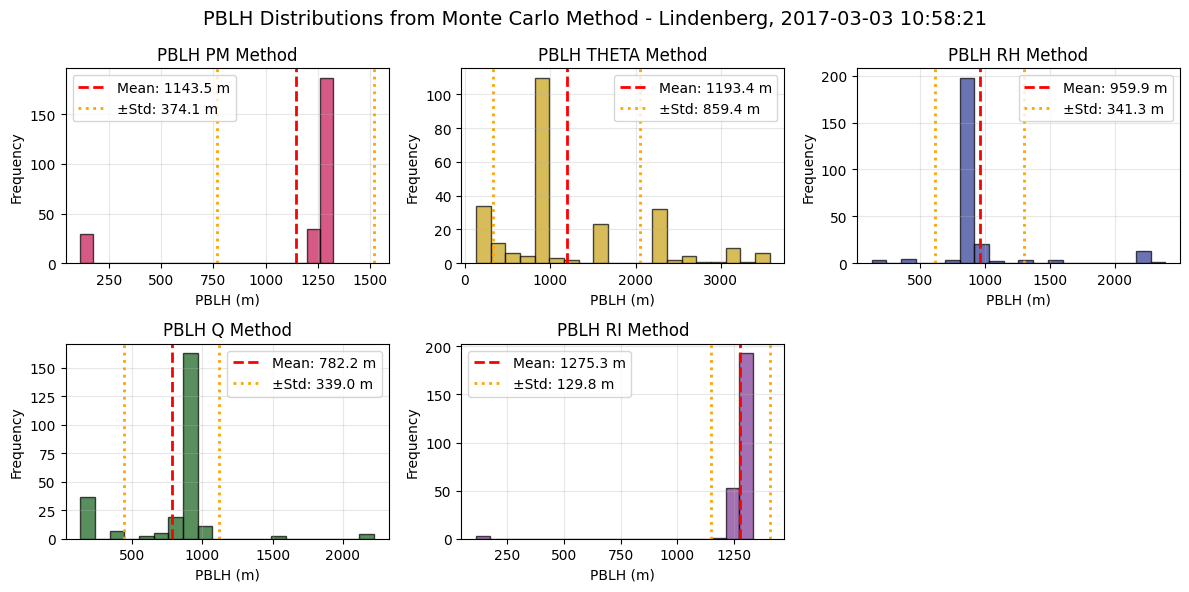

In [21]:
plt.figure(figsize=(12, 6))
methods = ['pm', 'theta', 'rh', 'q', 'Ri']
for idx, method in enumerate(methods, 1):
    plt.subplot(2, 3, idx)
    # Filter out None values
    samples = [s for s in pblh_samples[method] if s is not None]
    plt.hist(samples, bins=20, color=map_labels_to_colors['pblh_'+method], alpha=0.7, edgecolor='black')
    mean = np.nanmean(pblh_samples[method])
    std = np.nanstd(pblh_samples[method], ddof=1)
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f} m')
    plt.axvline(mean - std, color='orange', linestyle=':', linewidth=2, label=f'±Std: {std:.1f} m')
    plt.axvline(mean + std, color='orange', linestyle=':', linewidth=2)
    plt.xlabel('PBLH (m)')
    plt.ylabel('Frequency')
    plt.title(f'PBLH {method.upper()} Method')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle(f'PBLH Distributions from Monte Carlo Method - {where}, {when}', fontsize=14)
plt.tight_layout()
plt.show()

c:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


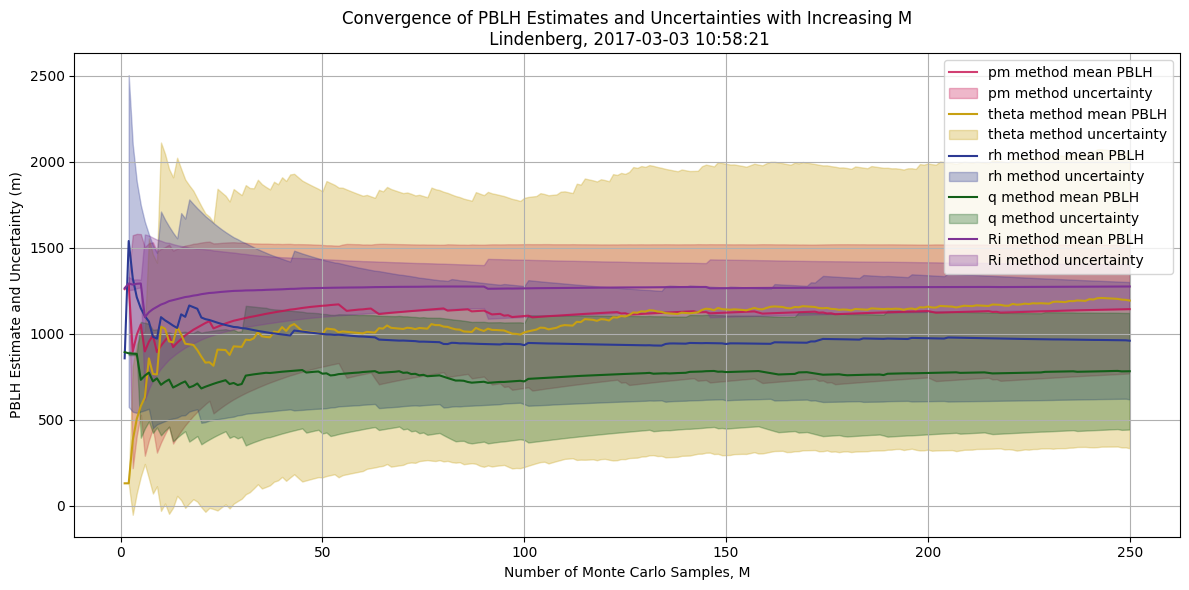

In [22]:
# compute mean and stddev of PBLH estimates with increasing M from Monte Carlo samples
increasing_M_results = []
for M in range(1, M+1):
    pblh_unc = {
        'pm': (np.nanmean(pblh_samples['pm'][:M]), np.nanstd(pblh_samples['pm'][:M], ddof=1)),
        'theta': (np.nanmean(pblh_samples['theta'][:M]), np.nanstd(pblh_samples['theta'][:M],ddof=1)),
        'rh': (np.nanmean(pblh_samples['rh'][:M]), np.nanstd(pblh_samples['rh'][:M], ddof=1)),
        'q': (np.nanmean(pblh_samples['q'][:M]), np.nanstd(pblh_samples['q'][:M], ddof=1)),
        'Ri': (np.nanmean(pblh_samples['Ri'][:M]), np.nanstd(pblh_samples['Ri'][:M], ddof=1)),
    }
    increasing_M_results.append(pblh_unc)
methods = ['pm', 'theta', 'rh', 'q', 'Ri']
plt.figure(figsize=(12, 6))

for method in methods:
    plbhs=[result[method][0] for result in increasing_M_results]
    uncs=[result[method][1] for result in increasing_M_results]
    plt.plot(range(1, M+1), plbhs, label=f'{method} method mean PBLH', color=map_labels_to_colors['pblh_'+method])
    plt.fill_between(range(1, M+1), np.array(plbhs) - np.array(uncs), np.array(plbhs) + np.array(uncs), alpha=0.3, 
                    label=f'{method} method uncertainty', color=map_labels_to_colors['pblh_'+method])

plt.xlabel('Number of Monte Carlo Samples, M')
plt.ylabel('PBLH Estimate and Uncertainty (m)')
plt.title(f'Convergence of PBLH Estimates and Uncertainties with Increasing M\n {where}, {when}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### 4.2 Gaussian Process $\epsilon$

Measurement errors can be modeled as Gaussian Process with a Covariance structure that enforce smoothness.

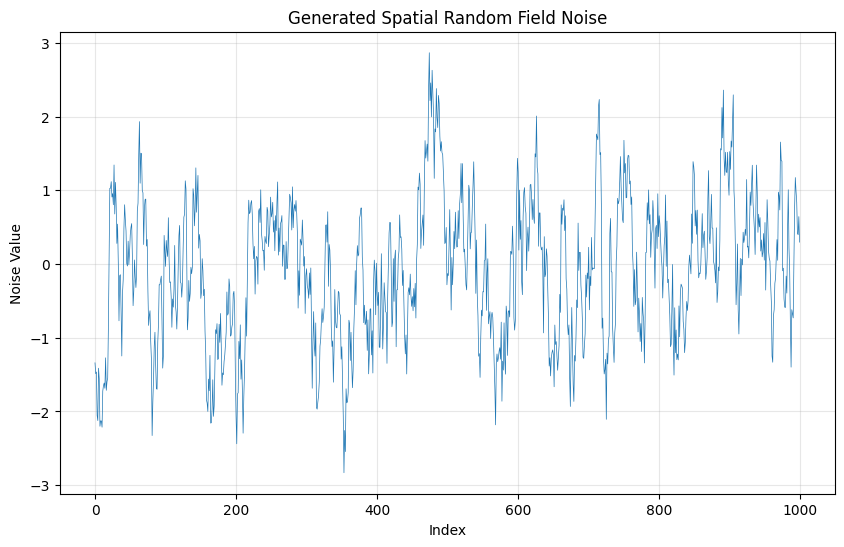

In [59]:
seed = MasterRNG(20251212)
noise_model=gs.Exponential(dim=1, var=1, len_scale=10)
noise_srf=gs.SRF(noise_model)
noises=noise_srf(range(1000), mesh_type='structured', seed=seed())
plt.figure(figsize=(10, 6))
plt.plot(range(len(noises)), noises, linewidth=0.5)
plt.xlabel('Index')
plt.ylabel('Noise Value')
plt.title('Generated Spatial Random Field Noise')
plt.grid(True, alpha=0.3)
plt.show()
    

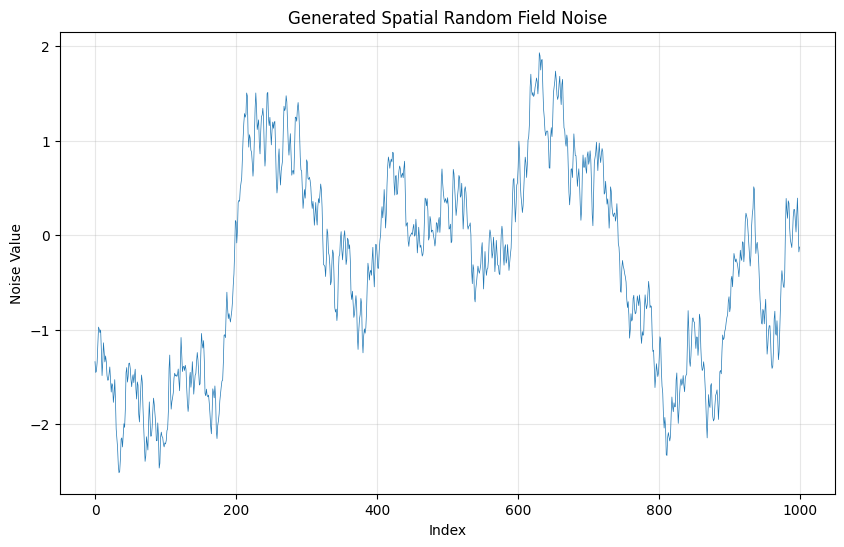

In [60]:
seed = MasterRNG(20251212)
noise_model=gs.Exponential(dim=1, var=1, len_scale=100)
noise_srf=gs.SRF(noise_model)
noises=noise_srf(range(1000), mesh_type='structured', seed=seed())
plt.figure(figsize=(10, 6))
plt.plot(range(len(noises)), noises, linewidth=0.5)
plt.xlabel('Index')
plt.ylabel('Noise Value')
plt.title('Generated Spatial Random Field Noise')
plt.grid(True, alpha=0.3)
plt.show()
    

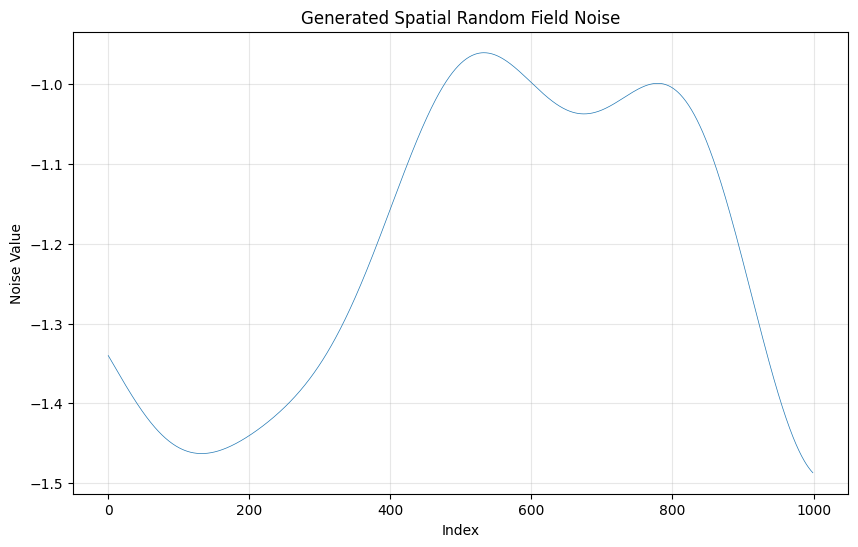

In [ ]:
seed = MasterRNG(20251212)
noise_model=gs.Exponential(dim=1, var=1, len_scale=1000)
noise_srf=gs.SRF(noise_model)
noises=noise_srf(range(1000), mesh_type='structured', seed=seed())
plt.figure(figsize=(10, 6))
plt.plot(range(len(noises)), noises, linewidth=0.5)
plt.xlabel('Index')
plt.ylabel('Noise Value')
plt.title('Generated Spatial Random Field Noise')
plt.grid(True, alpha=0.3)
plt.show()
    

In [61]:
# one model to fit them all (input quantities)
seed = MasterRNG(20251212)
noise_model=gs.Exponential(dim=1, var=1, len_scale=1000)
noise_srf=gs.SRF(noise_model)

M = 250
noisy_profiles = []
pblh_samples = {'pm': [], 'theta': [], 'rh': [], 'q': [], 'Ri': []}
noise_coeff = 0.5 # divide by k=2 to regain the standard combined uncertainty
for _ in tqdm(range(M)):
    data_noisy = gdp.data[VARIABLES].copy(deep=True) # make a copy of the data to add noise to
    data_noisy['alt'] += noise_srf(data_noisy['alt'], mesh_type='unstructured', seed=seed())*data_noisy['alt_uc']*noise_coeff # add noise to altitude
    data_noisy=data_noisy.sort_values('alt').reset_index(drop=True) # sort by altitude after noise addition
    for var in ['temp', 'rh', 'press', 'wspeed', 'wdir']:
        data_noisy[var] += noise_srf(data_noisy['alt'], mesh_type='unstructured', seed=seed())*data_noisy[var+'_uc']*noise_coeff # add noise to variable
        data_noisy = gp.parcel_method(data_noisy) # calculate PBLH using parcel method
    data_noisy = gp.potential_temperature_gradient(data_noisy, virtual=True) # calculate potential temperature gradient
    data_noisy = gp.RH_gradient(data_noisy) # calculate RH gradient
    data_noisy = gp.specific_humidity_gradient(data_noisy) # calculate specific humidity gradient
    data_noisy = gp.bulk_richardson_number_method(data_noisy) # calculate PBLH using bulk Richardson number method
    noisy_profiles.append(data_noisy) # store noisy profile
    # extract PBLH estimates from noisy profile
    pblh_samples['pm'].append(data_noisy['alt'][data_noisy['pblh_pm'] == 1].iloc[0] if 'pblh_pm' in data_noisy and any(data_noisy['pblh_pm'] == 1) else None)
    pblh_samples['theta'].append(data_noisy['alt'][data_noisy['pblh_theta'] == 1].iloc[0] if 'pblh_theta' in data_noisy and any(data_noisy['pblh_theta'] == 1) else None)
    pblh_samples['rh'].append(data_noisy['alt'][data_noisy['pblh_rh'] == 1].iloc[0] if 'pblh_rh' in data_noisy and any(data_noisy['pblh_rh'] == 1) else None)
    pblh_samples['q'].append(data_noisy['alt'][data_noisy['pblh_q'] == 1].iloc[0] if 'pblh_q' in data_noisy and any(data_noisy['pblh_q'] == 1) else 0)
    pblh_samples['Ri'].append(data_noisy['alt'][data_noisy['pblh_Ri'] == 1].iloc[0] if 'pblh_Ri' in data_noisy and any(data_noisy['pblh_Ri'] == 1) else 0)
# compute mean and stddev of PBLH estimates from Monte Carlo samples
pblh_uncertainty = {
    'pm': (np.nanmean(pblh_samples['pm']), np.nanstd(pblh_samples['pm'], ddof=1)),
    'theta': (np.nanmean(pblh_samples['theta']), np.nanstd(pblh_samples['theta'],ddof=1)),
    'rh': (np.nanmean(pblh_samples['rh']), np.nanstd(pblh_samples['rh'], ddof=1)),
    'q': (np.nanmean(pblh_samples['q']), np.nanstd(pblh_samples['q'], ddof=1)),
    'Ri': (np.nanmean(pblh_samples['Ri']), np.nanstd(pblh_samples['Ri'], ddof=1)),
}


100%|██████████| 250/250 [00:48<00:00,  5.18it/s]


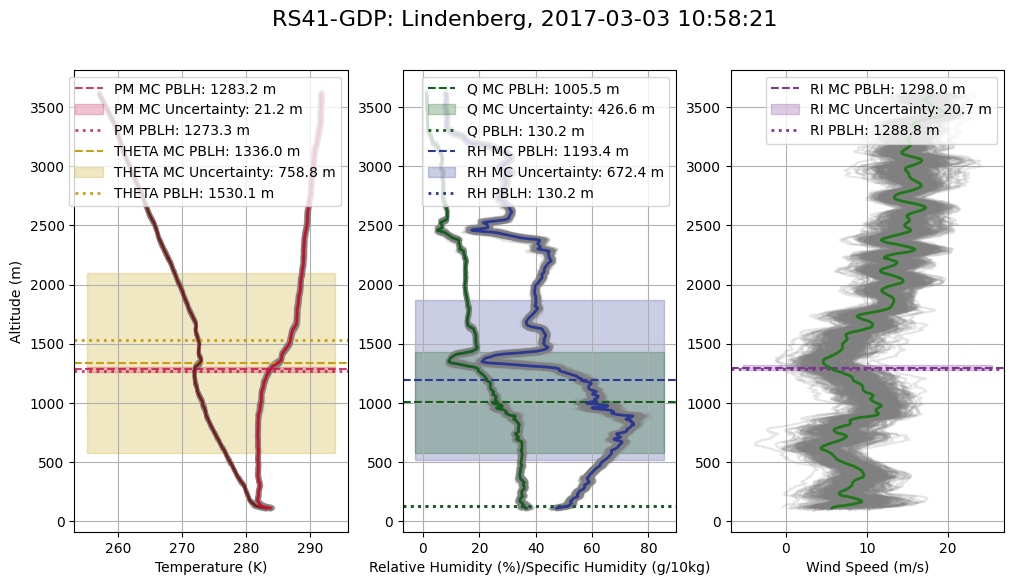

In [62]:
# plot noisy profiles with pblh estimates and uncertainties
plt.figure(figsize=(12, 6))
plt.suptitle(f'RS41-GDP: {where}, {when}'#, {file_index}'
            , fontsize=16)
# Temperature plot
ax1 = plt.subplot(1, 3, 1)
for sample in noisy_profiles: # plot all noisy profiles
    ax1.plot(sample['temp'], sample['alt'], color='gray', alpha=0.2)
    ax1.plot(sample['virtual_theta'], sample['alt'], color='gray', alpha=0.2)
ax1.plot(gdp.data['temp'], gdp.data['alt'], #label='True Temperature',
            color=map_labels_to_colors['temp'], linewidth=2, zorder=5) # plot true temperature
ax1.plot(gdp.data['virtual_theta'], gdp.data['alt'], #label='True Virtual Potential Temperature', 
                    color=map_labels_to_colors['virtual_theta'], linewidth=2, zorder=5) # plot true virtual potential temperature
if pblh_pm is not None: # plot PBLH line
    ax1.axhline(pblh_pm, color=map_labels_to_colors['pblh_pm'], linestyle=':', linewidth=2, label=f'PM PBLH: {pblh_pm:.1f} m')
if pblh_theta is not None: # plot PBLH line
    ax1.axhline(pblh_theta, color=map_labels_to_colors['pblh_theta'], linestyle=':', linewidth=2, label=f'THETA PBLH: {pblh_theta:.1f} m')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (m)')
ax1.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax1.get_xlim()[0],ax1.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    temperature_methods=['pm', 'theta']
    if mean is not None and label in temperature_methods:
        ax1.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax1.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# RH plot
ax2 = plt.subplot(1, 3, 2)
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['rh'], sample['alt'], color='gray', alpha=0.2)
ax2.plot(gdp.data['rh'], gdp.data['alt'], #label='True RH', 
            color=map_labels_to_colors['rh'], linewidth=2, zorder=5) # plot true RH
ax2.plot(gdp.data['q']*10000, gdp.data['alt'], #label='True Specific Humidity', 
                color=map_labels_to_colors['q'], linewidth=2, zorder=5) # plot true specific humidity
for sample in noisy_profiles: # plot all noisy profiles
    ax2.plot(sample['q']*10000, sample['alt'], color='gray', alpha=0.2)
if pblh_rh is not None: # plot PBLH line
    ax2.axhline(pblh_rh, color=map_labels_to_colors['pblh_rh'], linestyle=':', linewidth=2, label=f'RH PBLH: {pblh_rh:.1f} m')
if pblh_q is not None:
    ax2.axhline(pblh_q, color=map_labels_to_colors['pblh_q'], linestyle=':', linewidth=2, label=f'Q PBLH: {pblh_q:.1f} m')
ax2.set_xlabel('Relative Humidity (%)/Specific Humidity (g/10kg)')
ax2.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax2.get_xlim()[0],ax2.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    humidity_methods=['rh', 'q']
    if mean is not None and label in humidity_methods:
        ax2.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax2.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')

# wind speed plot
ax3 = plt.subplot(1, 3, 3)
for sample in noisy_profiles: # plot all noisy profiles
    ax3.plot(sample['wspeed'], sample['alt'], color='gray', alpha=0.2)
ax3.plot(gdp.data['wspeed'], gdp.data['alt'], #label='True Wind Speed', 
            color=map_labels_to_colors['wspeed'], linewidth=2, zorder=5) # plot true wind speed
if pblh_Ri is not None: # plot PBLH line
    ax3.axhline(pblh_Ri, color=map_labels_to_colors['pblh_Ri'], linestyle=':', linewidth=2, label=f'RI PBLH: {pblh_Ri:.1f} m')
ax3.set_xlabel('Wind Speed (m/s)')
ax3.grid()
# Add PBLH lines and uncertainty bands
for label, (mean, std) in pblh_uncertainty.items():
    if mean is not None and label in ['Ri']:
        ax3.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax3.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=ax3.get_xlim()[0],
            x2=ax3.get_xlim()[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.25,
            label=f'{label.upper()} MC Uncertainty: {std:.1f} m'
        )
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda pair: pair[0])
sorted_labels, sorted_handles = zip(*sorted_pairs)
plt.legend(sorted_handles, sorted_labels, loc='upper right')


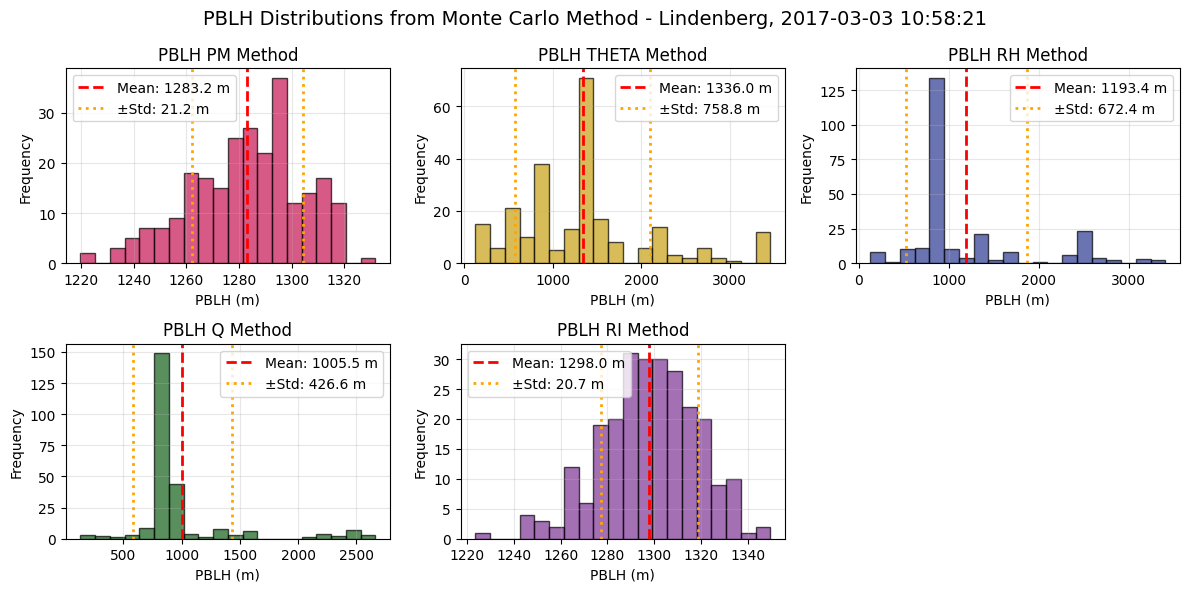

In [63]:
plt.figure(figsize=(12, 6))
methods = ['pm', 'theta', 'rh', 'q', 'Ri']
for idx, method in enumerate(methods, 1):
    plt.subplot(2, 3, idx)
    # Filter out None values
    samples = [s for s in pblh_samples[method] if s is not None]
    plt.hist(samples, bins=20, color=map_labels_to_colors['pblh_'+method], alpha=0.7, edgecolor='black')
    mean = np.nanmean(pblh_samples[method])
    std = np.nanstd(pblh_samples[method], ddof=1)
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f} m')
    plt.axvline(mean - std, color='orange', linestyle=':', linewidth=2, label=f'±Std: {std:.1f} m')
    plt.axvline(mean + std, color='orange', linestyle=':', linewidth=2)
    plt.xlabel('PBLH (m)')
    plt.ylabel('Frequency')
    plt.title(f'PBLH {method.upper()} Method')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle(f'PBLH Distributions from Monte Carlo Method - {where}, {when}', fontsize=14)
plt.tight_layout()
plt.show()

### 4.3 Modelling S and $\epsilon$ residuals

Basic idea:
- fit a model to vertical profiles of input quantities ($S$), which model? Statistical model (state-space model), NN model (autoencoders), PINN model (ideal gas equation regularized autoencoders)
- compute the residual of the observation with respect to the model as an estimation for $\epsilon$, a good model will leave just uncorrelated error?
- fit a GP model to the residual ($\epsilon$)
- sample realization of $\epsilon$ and obtain profiles conditioned on the realization of $S$

### 4.4 Temperature Uncertainty Matrix from correlated uncertainty

Independence assumption leads to big PBLH MCM uncertainty, Gaussian (Spatial) Processes can fix this issue!

For reference see "Model Based Geostatistics - Diggle, Ribeiro"

A Gaussian spatial process $\{S(x):x\in R^2\}$ is stochastic process s.t. for any collection of locations $x_1,\,...\,,x_n$ the joint distribution of $S=\{S(x_1),\,...\,,S(x_n)\}$ is multivariate Gaussian. It is completely specified by its mean function $\mu(x)=E(S(x))$ and covariance function $\gamma(x,x')=Cov(S(x),S(x'))$. (Abuse of notation, here $x$ is not an input quantity but a position, $S(x)$ is modelling the input quantity)

The simples extension might be the following: consider a generic input quantity $\boldsymbol{X}=(X_1,\,...\,,X_n)$. Assume measurement equation
$$X=\mu+S$$
where $E(Y)=\mu$, and the spatial signal $S\sim MVN(0,\Sigma)$

Given $\Sigma$, $S$ can be simulated thanks to the singular value decomposition, $\Sigma=U\Lambda U$; by $S=AZ$ where $Z=(Z_1,\,...\,,Z_n))$ with $Z_i\sim N(0,1)$ and $A=U\Lambda^{1/2}$.

RS41-GDP.1 for each temperature measurement, provide the uncorrelated and the spatially correlated component. So according to GUM the uncertainty or correlation matrix $\Sigma$ can be defined as $$\Sigma=\begin{bmatrix}
u^2(x_1) & ... & u_{cor}(x_1)u_{cor}(x_N) \\
... & ... & ... \\
u_{cor}(x_N)u_{cor}(x_1) & ... & u^2(x_N)
\end{bmatrix}.$$ 

Actually, temperature is the only one having a spatially correlated component!

In [36]:
# Monte Carlo simulation
M=250
noisy_profiles = []
pblh_samples = {'pm': [], 'theta': []}
Z=gp.uncertainty_matrix(gdp.data, variable_clmn='temp')
U, S, Vt = np.linalg.svd(Z)
A = U @ np.sqrt(np.diag(S))  # get matrix A from SVD
N = len(gdp.data)

for i in tqdm(range(M)):
    data_noisy = gdp.data.copy(deep=True) # make a copy of the data to add noise to
    np.random.seed(i)
    standard_normal_samples = np.random.normal(0, 1, N)
    noise = A @ standard_normal_samples 
    data_noisy['temp'] += noise # add noise to variable
        
    data_noisy = gp.parcel_method(data_noisy) # calculate PBLH using parcel method
    data_noisy = gp.potential_temperature_gradient(data_noisy, virtual=True) # calculate potential temperature gradient
    noisy_profiles.append(data_noisy) # store noisy profile
    # extract PBLH estimates from noisy profile
    pblh_samples['pm'].append(data_noisy['alt'][data_noisy['pblh_pm'] == 1].iloc[0] if 'pblh_pm' in data_noisy and any(data_noisy['pblh_pm'] == 1) else None)
    pblh_samples['theta'].append(data_noisy['alt'][data_noisy['pblh_theta'] == 1].iloc[0] if 'pblh_theta' in data_noisy and any(data_noisy['pblh_theta'] == 1) else None)
# compute mean and stddev of PBLH estimates from Monte Carlo samples
pblh_uncertainty = {
    'pm': (np.nanmean(pblh_samples['pm']), np.nanstd(pblh_samples['pm'], ddof=1)),
    'theta': (np.nanmean(pblh_samples['theta']), np.nanstd(pblh_samples['theta'],ddof=1)),
}

100%|██████████| 250/250 [00:01<00:00, 182.78it/s]


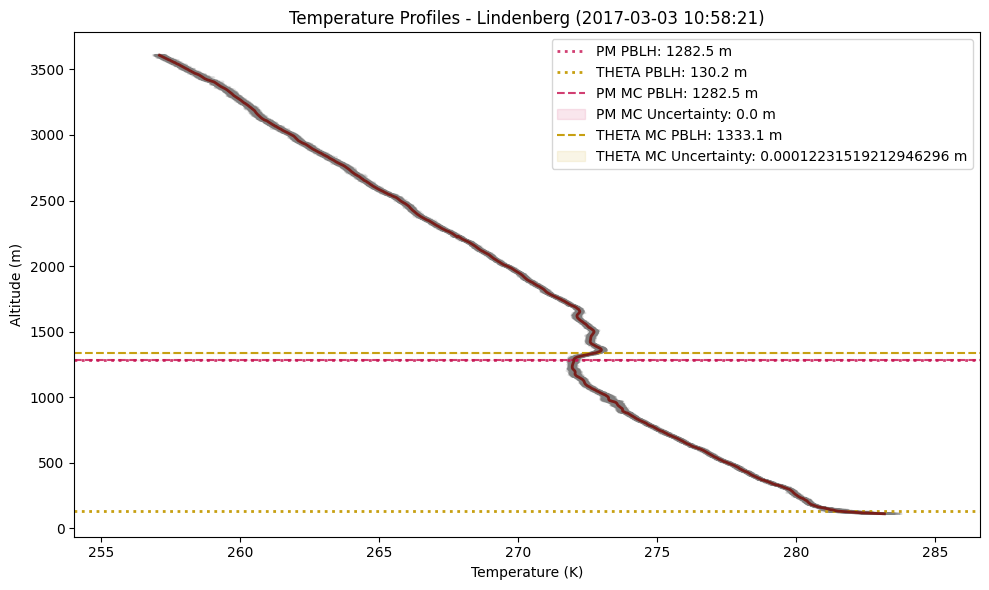

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(gdp.data['temp'], gdp.data['alt'], color=map_labels_to_colors['temp'], linewidth=2, zorder=5)
for i, profile in enumerate(noisy_profiles):
    ax.plot(profile['temp'], profile['alt'], color='gray', alpha=0.2)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Altitude (m)')
ax.set_title(f'Temperature Profiles - {where} ({when})')
ax.legend(['Original'] + [f'MC Sample {i+1}' for i in range(min(5, len(noisy_profiles)))])
ax.grid(True, alpha=0.3)

if pblh_pm is not None: # plot PBLH line
    ax.axhline(pblh_pm, color=map_labels_to_colors['pblh_pm'], linestyle=':', linewidth=2, label=f'PM PBLH: {pblh_pm:.1f} m')
if pblh_theta is not None: # plot PBLH line
    ax.axhline(pblh_theta, color=map_labels_to_colors['pblh_theta'], linestyle=':', linewidth=2, label=f'THETA PBLH: {pblh_theta:.1f} m')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Altitude (m)')
ax.grid()
# Add PBLH lines and uncertainty bands
x_bounds=[ax.get_xlim()[0],ax.get_xlim()[1]]
for label, (mean, std) in pblh_uncertainty.items():
    temperature_methods=['pm', 'theta']
    if mean is not None and label in temperature_methods:
        ax.axhline(mean, linestyle='--', label=f'{label.upper()} MC PBLH: {mean:.1f} m', color=map_labels_to_colors['pblh_'+label])
        ax.fill_betweenx(
            y=np.array([mean - std, mean + std]),
            x1=x_bounds[0],
            x2=x_bounds[1],
            color=map_labels_to_colors['pblh_'+label],
            alpha=0.1,
            label=f'{label.upper()} MC Uncertainty: {std} m'
        )

plt.tight_layout()
plt.legend()
plt.show()


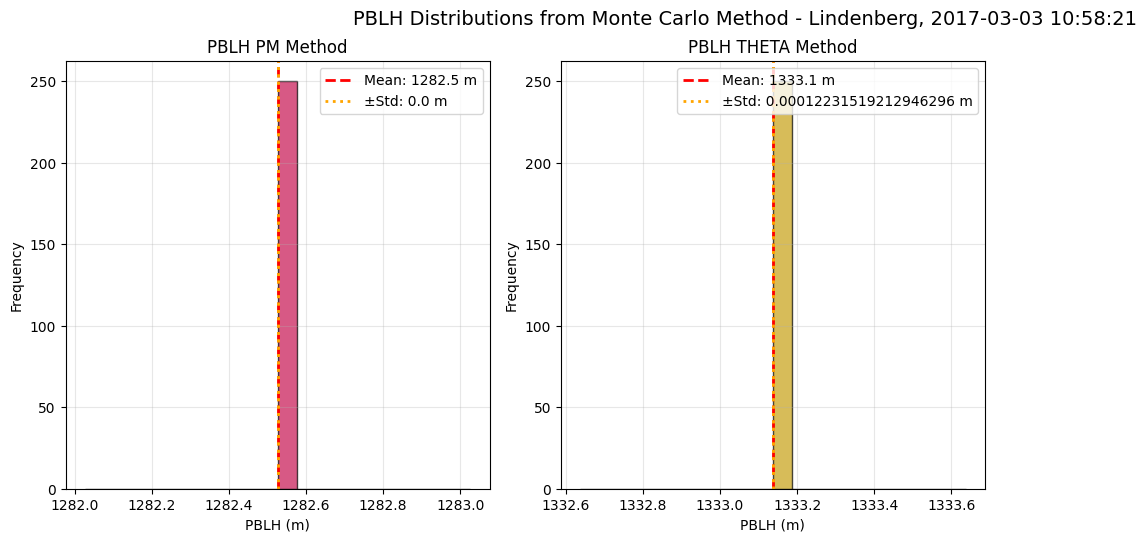

In [38]:
plt.figure(figsize=(15, 10))
methods = ['pm', 'theta']
for idx, method in enumerate(methods, 1):
    plt.subplot(2, 3, idx)
    # Filter out None values
    samples = [s for s in pblh_samples[method] if s is not None]
    plt.hist(samples, bins=20, color=map_labels_to_colors['pblh_'+method], alpha=0.7, edgecolor='black')
    mean = np.nanmean(pblh_samples[method])
    std = np.nanstd(pblh_samples[method], ddof=1)
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f} m')
    plt.axvline(mean - std, color='orange', linestyle=':', linewidth=2, label=f'±Std: {std} m')
    plt.axvline(mean + std, color='orange', linestyle=':', linewidth=2)
    plt.xlabel('PBLH (m)')
    plt.ylabel('Frequency')
    plt.title(f'PBLH {method.upper()} Method')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle(f'PBLH Distributions from Monte Carlo Method - {where}, {when}', fontsize=14)
plt.tight_layout()
plt.show()